## Import necessary libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.metrics import r2_score, mean_squared_error
sb.set() # set the default Seaborn style for graphics

## Extract csv file


In [2]:
data = pd.read_csv('resale-flat-prices-based-on-approval-date-2000-feb-2012.csv')
data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0
1,2000-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0
2,2000-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0
3,2000-01,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0
4,2000-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0


## To obtain `CombinedDataCleaned` (no outliers from both NumData and CatData)


In [3]:
NumData = pd.DataFrame(data[['floor_area_sqm', 'lease_commence_date']])

In [4]:
flat_type = pd.DataFrame(data[['flat_type']])
mapping = {'1 ROOM': 1, '2 ROOM': 2, '3 ROOM': 3, '4 ROOM': 4, '5 ROOM': 5, 'EXECUTIVE': 6, 'MULTI-GENERATION': 7}
data['flat_type_num'] = flat_type['flat_type'].map(mapping)

storey_range = pd.DataFrame(data[['storey_range']])
mapping = {'01 TO 03': 2, '04 TO 06': 5, '07 TO 09': 8, '10 TO 12': 11, '13 TO 15': 14, '16 TO 18': 17, '19 TO 21': 20, '22 TO 24': 23, '25 TO 27': 26, '28 TO 30': 29, '31 TO 33': 32, '34 TO 36': 35, '37 TO 39': 38, '40 TO 42': 41}
data['Story_range_num'] = storey_range["storey_range"].map(mapping)

flat_model = pd.DataFrame(data[['flat_model']])
mapping = {'2-room': 1, 'Adjoined flat': 2, 'Apartment': 3, 'Improved': 4, 'Improved-Maisonette': 5, 'Maisonette': 6, 'Model A': 7, 'Model A-Maisonette': 8, 'Model A2': 9, 'Multi Generation': 10, 'New Generation': 11, 'Premium Apartment': 12, 'Premium Maisonette': 13, 'Simplified': 14, 'Standard': 15, 'Terrace': 16}
data['flat_model_num'] = flat_model['flat_model'].map(mapping)

CatData = pd.DataFrame(data[['flat_type_num', 'Story_range_num','flat_model_num']])

CombinedDataCleaned = pd.concat([NumData, CatData,data['resale_price']], axis=1)

CombinedDataCleaned.info()

# Calculate the quartiles
Q1 = CombinedDataCleaned.quantile(0.25)
Q3 = CombinedDataCleaned.quantile(0.75)

# Rule to identify outliers
rule = ((CombinedDataCleaned < (Q1 - 1.5 * (Q3 - Q1))) | (CombinedDataCleaned > (Q3 + 1.5 * (Q3 - Q1))))

outliers = rule.any(axis = 1)   # axis 0 is row, 1 is column

# Which row indices correspond to outliers in the dataframe?
outlierindices = outliers.index[outliers == True]



# Remove the outliers based on the row indices obtained above
CombinedDataCleaned.drop(axis = 0,               # 0 drops row 1 drops column
                index = outlierindices, # this takes a list as input
                inplace = True)         # not overwritten by default 

# Check the clean data
CombinedDataCleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369651 entries, 0 to 369650
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   floor_area_sqm       369651 non-null  float64
 1   lease_commence_date  369651 non-null  int64  
 2   flat_type_num        369651 non-null  int64  
 3   Story_range_num      369651 non-null  int64  
 4   flat_model_num       369651 non-null  int64  
 5   resale_price         369651 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 16.9 MB
<class 'pandas.core.frame.DataFrame'>
Index: 360419 entries, 0 to 369648
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   floor_area_sqm       360419 non-null  float64
 1   lease_commence_date  360419 non-null  int64  
 2   flat_type_num        360419 non-null  int64  
 3   Story_range_num      360419 non-null  int64  
 4   flat_model_num 

# We will compare the R^2 and MSE for all three models to determine the best model and also check the feature importance score to determine which predictors are the best 

## LASSO REGRESSION

**Reasons for Lasso Regression** <br>

We used Lasso Regression because there are many potential predictors that are important in predicting `resale_price`. <br>

Lasso regression help to perform variable selection by penalizing the regression coefficients of less important variables, <br>
which can help to reduce overfitting and improve the generalizability of the model.

**Detailed & formal introduction to your model** <br>

**Input** <br>
Dataset with one or more predictor variables (X) <br>
A corresponding outcome variable (y) --> `resale_price`

**Output** <br>
Set of regression coefficients (β), which can be used to make predictions on new data

**How we trained and choice of hyperparameters of  model**
1. We split the dataset into training and test sets, with random_state = 42 as is the convention in the machine learning community and to ensure that the results of the analysis are reproducible.<br>
2. We use LassoCV function to perform cross-validation and find the optimal value of the regularization parameter (lambda) for the model.
3. 5-fold Cross Validation, CV is used as it strikes a balance between bias and variance
4. The best value of alpha (α) is the penalty term that denotes the amount of shrinkage (or constraint) that will be implemented in the equation, is obtained and fit into our model from 5-fold CV
5. Feature Importance Scores are computed and printed to see which predictors are the best
6. Performance metrics of MSE and R^2 are computed for train and test data and Predicted vs True values are plotted to provide analysis of the model
7. At the end, conclude with the performance metrics and features importance.

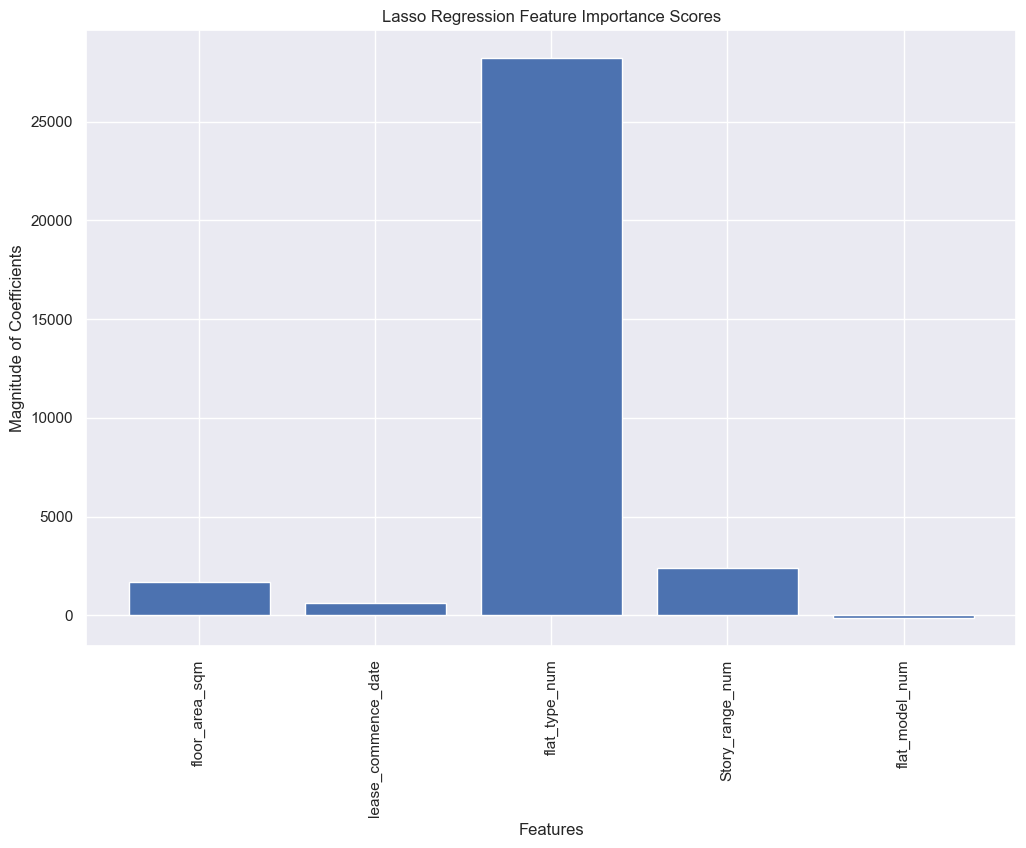

flat_type_num: 28195.77
Story_range_num: 2380.19
floor_area_sqm: 1706.35
lease_commence_date: 631.44
flat_model_num: -152.70


In [5]:
import pandas as pd
from sklearn.linear_model import Lasso,LassoCV
from sklearn.model_selection import train_test_split

# Concatenate the numerical and categorical variables
X = CombinedDataCleaned.iloc[:, 0:5] # get columns 0 to 4
y = CombinedDataCleaned['resale_price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Lasso Regression model with cross-validation to find the best value of alpha
model = LassoCV(cv=5)
model.fit(X, y)

# Fit the Lasso Regression model
model = Lasso(alpha=model.alpha_)
model.fit(X_train, y_train)

# Predict using the Lasso Regression model on test data
y_pred = model.predict(X_test)

# Calculate R-squared and MSE on test data
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Get the coefficients of the model
coef = model.coef_

# Plot the feature importance scores
plt.figure(figsize=(12,8))
plt.bar(range(len(coef)), coef)
plt.xticks(range(len(coef)), X.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Magnitude of Coefficients')
plt.title('Lasso Regression Feature Importance Scores')
plt.show()

# Create a dictionary of feature importance scores
feature_scores = {feature: score for feature, score in zip(X.columns, coef)}

# Sort the dictionary by value in descending order
sorted_scores = sorted(feature_scores.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the feature importance scores in descending order
for feature, score in sorted_scores:
    print('{}: {:.2f}'.format(feature, score))

## Best hyperparameters for Lasso Regressionn

In [9]:
print("Best alpha:", model.alpha)

Best alpha: 1816.1024738794094


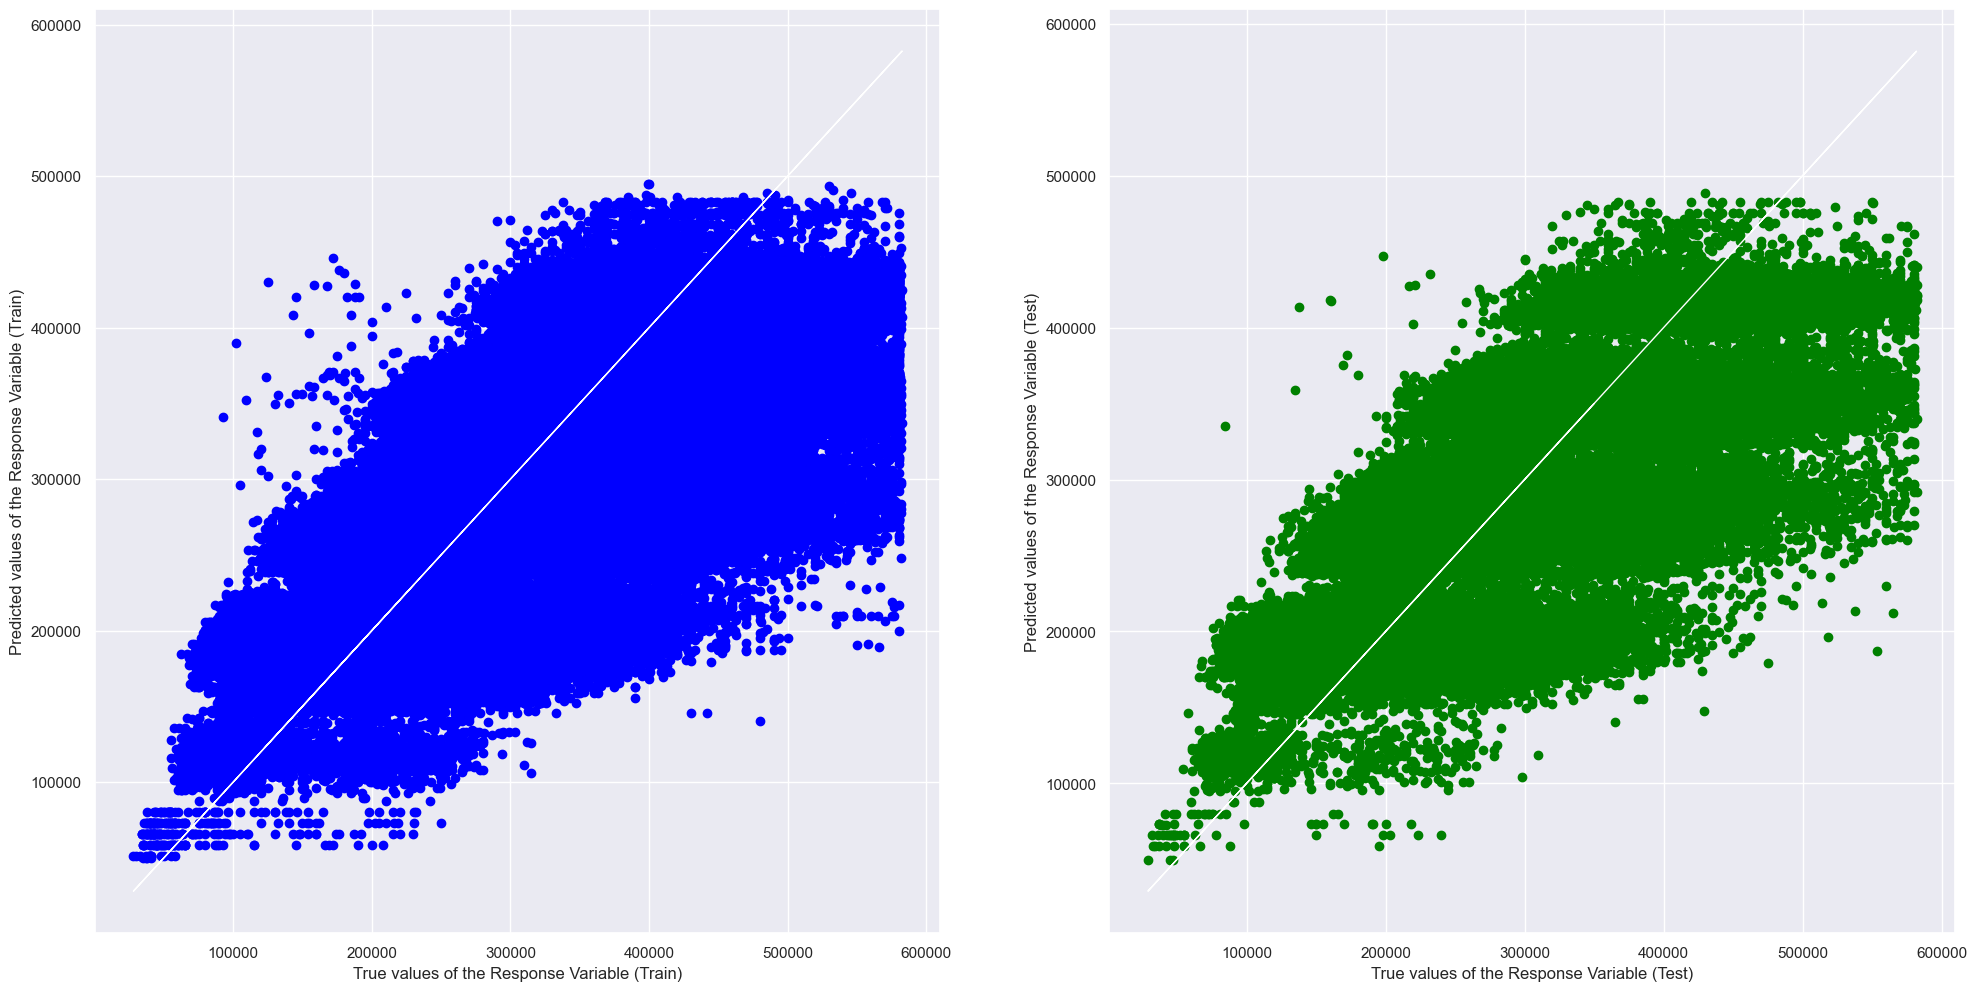

In [6]:
import matplotlib.pyplot as plt

# Predict on training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [7]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", model.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, model.predict(X_train)))
print()

# Check the Goodness of Fit (on Test Data)
print("Prediction Accuracy of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2)
print("Mean Squared Error (MSE) \t:", mse)
print()


Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5259255425102897
Mean Squared Error (MSE) 	: 4963562519.526854

Prediction Accuracy of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5288131519038053
Mean Squared Error (MSE) 	: 4956720673.498274



## GRADIENT BOOSTING REGRESSION

**Reasons for Gradient Boosting Regression** <br>

We used Gradient Boosting because it has more flexibility to capture complex relationships between the input features and output `resale_price`. <br>

Gradient Boosting sequentially adding weak models (usually decision trees) to a ensemble model in a way that minimizes the overall prediction error. <br>

Each new model is designed to correct the mistakes of the previous models. This leads to a strong ensemble model that can generalize well to new, unseen data.<br>


**Detailed & formal introduction to your model** <br>

**Input** <br>
Dataset with one or more predictor variables (X) that produces corresponding outcome variable (y) --> `resale_price` <br>

**Output** <br>
Set of predictions for the target variable y, based on the input features X, made by combining the predictions of multiple weaker models. <br>
The final prediction is the sum of the predictions of all the weaker models

**How we trained and choice of hyperparameters of  model**
1. We split the dataset into training and test sets, with random_state = 42 as is the convention in the machine learning community and to ensure that the results of the analysis are reproducible.<br>
2. We use GridSearchCV function to perform cross-validation and find the optimal value of the parameter for `learning_rate` and `n_estimators` for the model.
3. 5-fold CV is used as it strikes a balance between bias and variance
4. The best value of `learning_rate` and `n_estimators` is obtained and fit into our model from 5-fold CV
5. Feature Importance Scores are computed and printed to see which predictors are the best
6. Performance metrics of MSE and R^2 are computed for train and test data and Predicted vs True values are plotted to provide analysis of the model
7. For the hyperparameters 'learning_rate': [0.01, 0.1, 1] and 'n_estimators': [50, 100, 200], there are a total of 9 possible combinations, 5-fold cross-validation, we will train and evaluate the model 45 times to obtain the best combination for our model.
8. At the end, conclude with the performance metrics and features importance.

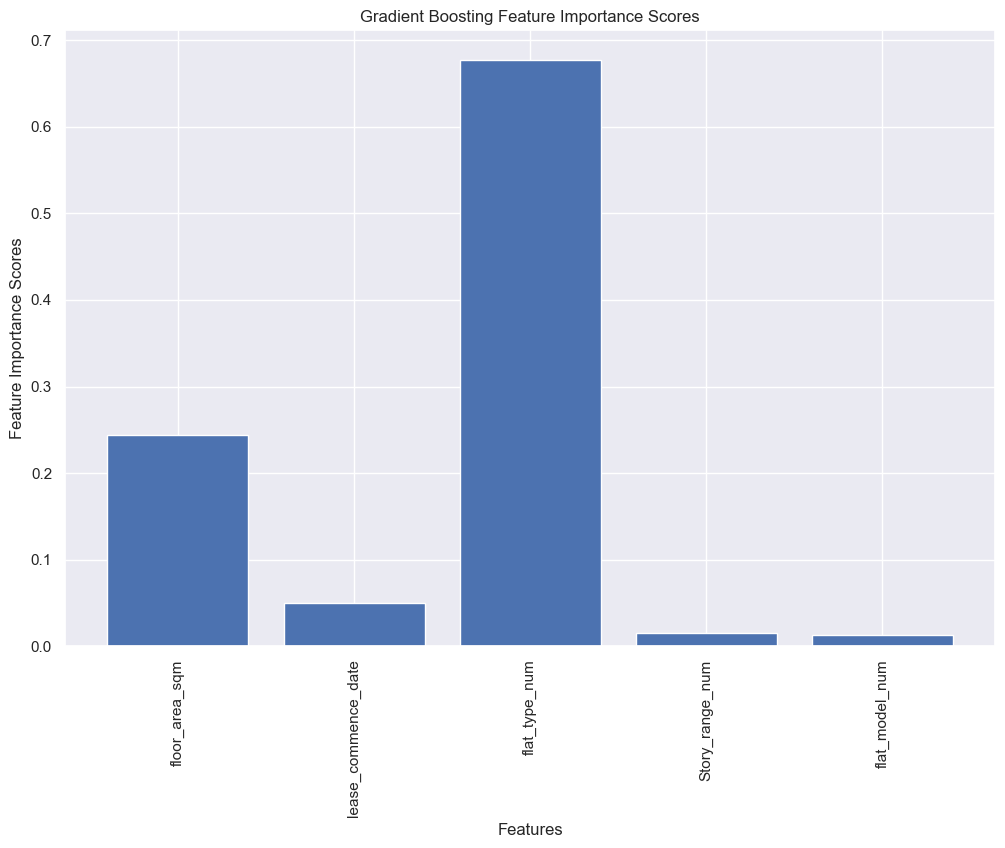

flat_type_num: 0.68
floor_area_sqm: 0.24
lease_commence_date: 0.05
Story_range_num: 0.02
flat_model_num: 0.01


In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV


# Concatenate the numerical and categorical variables
X = CombinedDataCleaned.iloc[:, 0:5] # get columns 0 to 4
y = CombinedDataCleaned['resale_price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters to tune
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [50, 100, 200]
}

# Create a Gradient Boosting Regressor object
gbr = GradientBoostingRegressor(random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(gbr, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Train the Gradient Boosting Regressor with the best hyperparameters
best_gbr = GradientBoostingRegressor(learning_rate=grid_search.best_params_['learning_rate'], 
                                      n_estimators=grid_search.best_params_['n_estimators'], 
                                      random_state=42)
best_gbr.fit(X_train, y_train)

# Predict using the Gradient Boosting Regressor model on test data
y_pred = best_gbr.predict(X_test)

# Calculate R-squared and MSE on test data
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Get the best Gradient Boosting model
best_gbr = grid_search.best_estimator_

# Get the feature importance scores
feature_importances = best_gbr.feature_importances_

# Create a bar plot of the feature importance scores
plt.figure(figsize=(12,8))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xticks(range(len(feature_importances)), X.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance Scores')
plt.title('Gradient Boosting Feature Importance Scores')
plt.show()

# Print the feature importance scores in descending order
sorted_scores = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)
for feature, score in sorted_scores:
    print('{}: {:.2f}'.format(feature, score))

## Best hyperparameters for Gradient Boosting

In [12]:
print("Best n_estimators:", grid_search.best_params_['n_estimators'])
print("Best learning_rate:", grid_search.best_params_['learning_rate'])

Best n_estimators: 200
Best learning_rate: 1


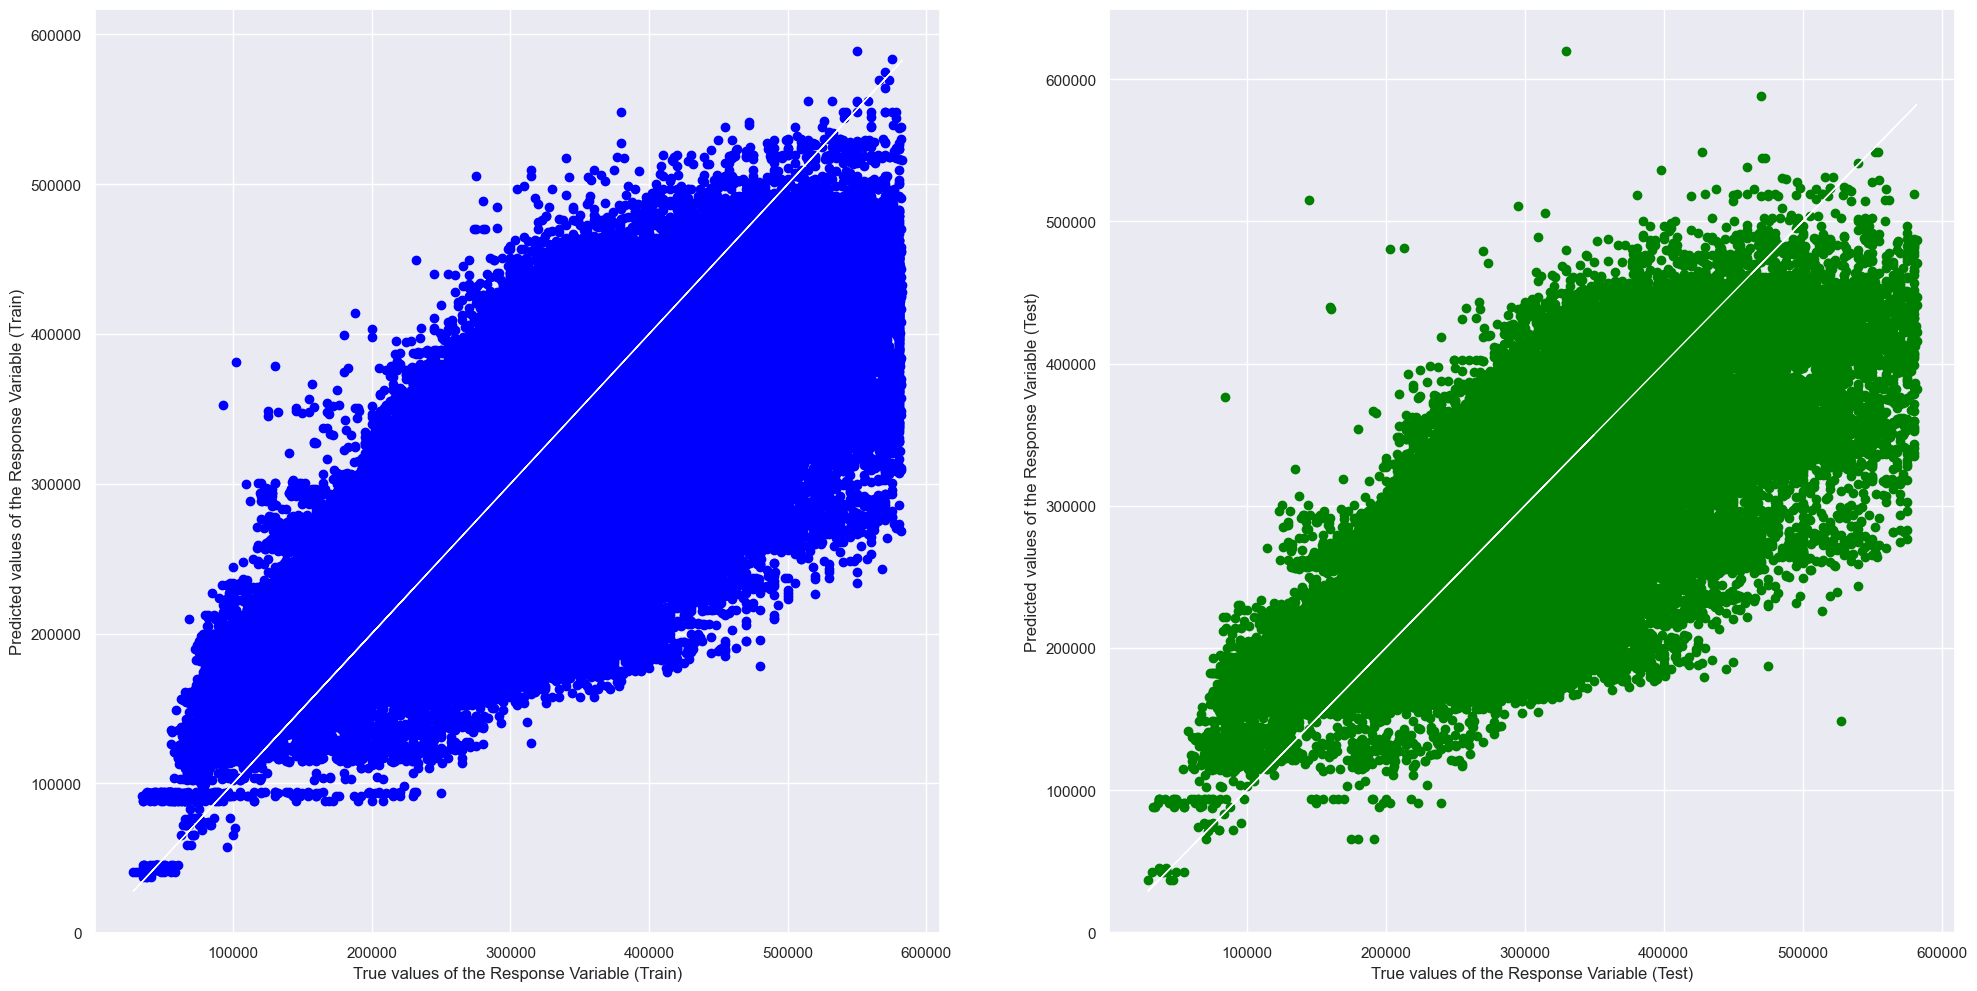

In [10]:
import matplotlib.pyplot as plt

# Predict on training and test data
y_train_pred = best_gbr.predict(X_train)
y_test_pred = best_gbr.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [11]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", best_gbr.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, model.predict(X_train)))
print()

# Check the Goodness of Fit (on Test Data)
print("Prediction Accuracy of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2)
print("Mean Squared Error (MSE) \t:", mse)
print()


Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5924240911806635
Mean Squared Error (MSE) 	: 4963562519.526854

Prediction Accuracy of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5909936964049025
Mean Squared Error (MSE) 	: 4302603115.541636



## RANDOM FOREST

**Reasons for Random Forest Regression** <br>

We used Random Forest because Random Forest can handle a large number of input features, which is useful for predicting HDB resale prices, as there are many factors that can influence the output `resale price`. <br>

Random Forest is less prone to overfitting, making it a good choice for complex problems like predicting HDB resale prices <br>


**Detailed & formal introduction to your model** <br>

**Input** <br>
Dataset with one or more predictor variables (X) that produces corresponding outcome variable (y) --> `resale_price` <br>

**Output** <br>
Predicted resale price of the flat based on the inputs <br>

**How we trained and choice of hyperparameters of  model**
1. We split the dataset into training and test sets, with random_state = 42 as is the convention in the machine learning community and to ensure that the results of the analysis are reproducible.<br>
2. We use GridSearchCV function to perform cross-validation and find the optimal value of the parameter for `max_depth` and `n_estimators` for the model.
3. 5-fold CV is used as it strikes a balance between bias and variance
4. The best value of `max_depth` and `n_estimators` is obtained and fit into our model from 5-fold CV
5. Feature Importance Scores are computed and printed to see which predictors are the best
6. Performance metrics of MSE and R^2 are computed for train and test data and Predicted vs True values are plotted to provide analysis of the model
7. For the hyperparameters 'max_depth': [5, 10, 20], and 'n_estimators': [100, 200, 500], there are a total of 9 possible combinations, 5-fold cross-validation, we will train and evaluate the model 45 times to obtain the best combination for our model. 
8. 5, 10, and 20 for `max_depth` are used in random forest because they prevent overfitting by limiting the depth of each tree.
9. 100, 200, and 500 for `n_estimators` are chosen because they provide a good trade-off between computation time and model performance.
10. At the end, conclude with the performance metrics and features importance.

In [12]:
# Import Required Libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV

# Concatenate the numerical and categorical variables
X = CombinedDataCleaned.iloc[:, 0:5] # get columns 0 to 4
y = CombinedDataCleaned['resale_price']

# Split the Dataset into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters to tune
param_grid = {
    'max_depth': [5, 10, 20],
    'n_estimators': [100, 200, 500]
}

# Instantiate a Random Forest Regressor model
rf = RandomForestRegressor(random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_max_depth = grid_search.best_params_['max_depth']
best_n_estimators = grid_search.best_params_['n_estimators']

# Fit the Random Forest Regressor model with the best hyperparameters
rf_best = RandomForestRegressor(max_depth=best_max_depth, n_estimators=best_n_estimators, random_state=42)
rf_best.fit(X_train, y_train)

# Predict using the Random Forest Regressor model on test data
y_pred = rf_best.predict(X_test)

# Calculate R-squared and MSE on test data
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print the Feature Importances
importances = rf_best.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature '%s' (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))


Feature ranking:
1. feature 'flat_type_num' (0.647144)
2. feature 'floor_area_sqm' (0.237785)
3. feature 'lease_commence_date' (0.074414)
4. feature 'Story_range_num' (0.026848)
5. feature 'flat_model_num' (0.013810)


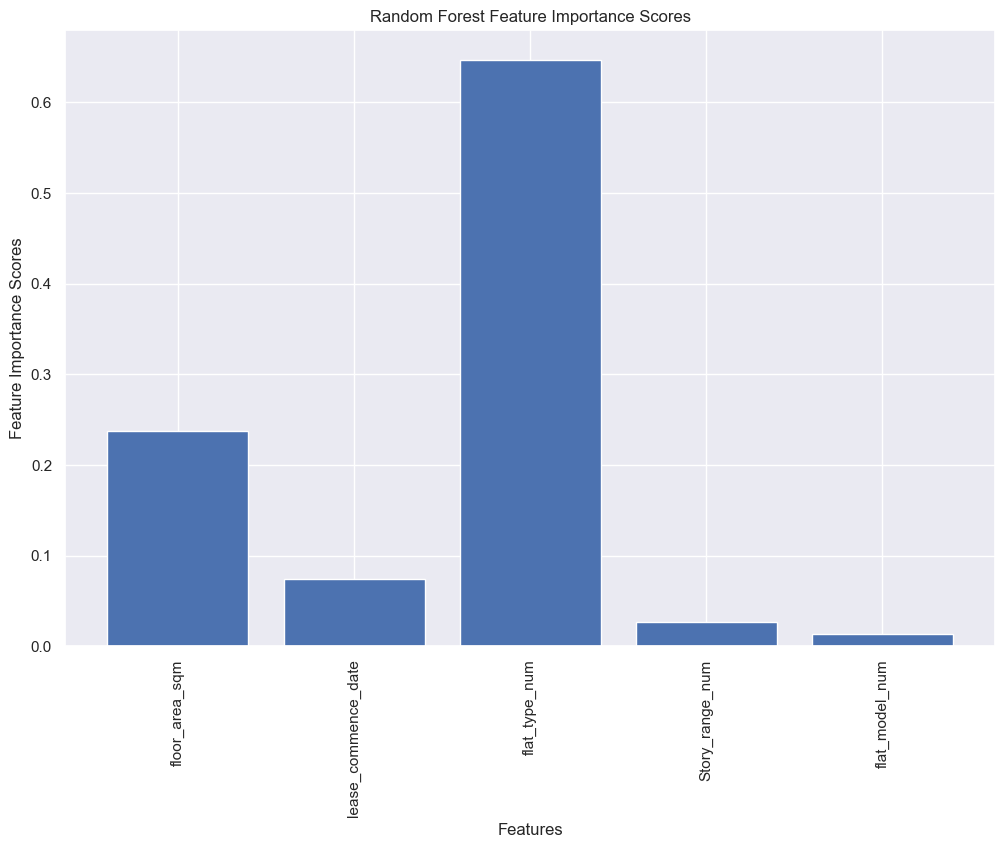

In [8]:
# Create a bar plot of the feature importance scores
plt.figure(figsize=(12,8))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), X.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance Scores')
plt.title('Random Forest Feature Importance Scores')
plt.show()

## Best hyperparameters for Random Forest

In [15]:
print("best_max_depth",best_max_depth)
print("best_n_estimators",best_n_estimators)

best_max_depth 20
best_n_estimators 500


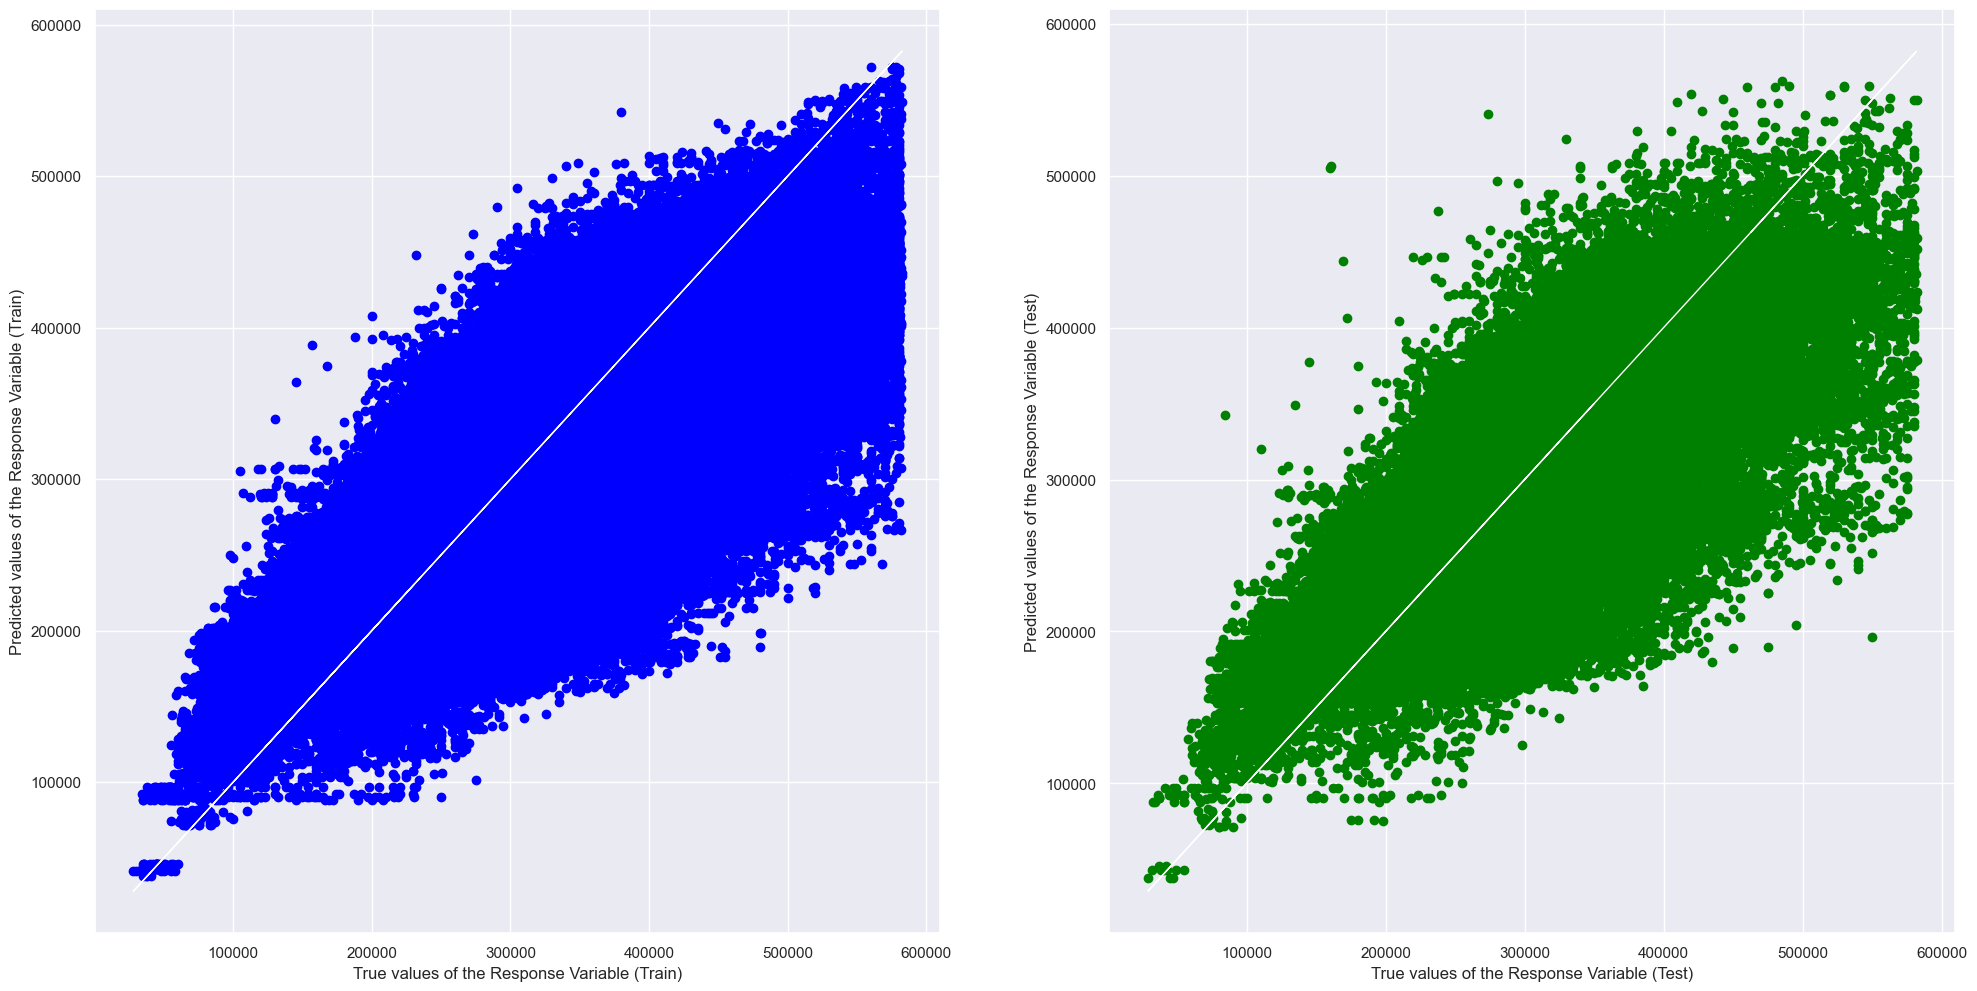

In [16]:
import matplotlib.pyplot as plt

# Predict on training and test data
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [18]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", rf_best.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, rf_best.predict(X_train)))
print()

# Check the Goodness of Fit (on Test Data)
print("Prediction Accuracy of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2)
print("Mean Squared Error (MSE) \t:", mse)
print()


Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6186643107285571
Mean Squared Error (MSE) 	: 3992587039.2769575

Prediction Accuracy of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5919017226199024
Mean Squared Error (MSE) 	: 4293050997.6712976



# Analysis of the 3 models and Predictors in predicting `resale_price`

**Briefly introduce which baselines you are comparing with, e.g. you compare your model against a random guessing, a decision tree, a linear model, etc**

-All the 3 different models, `Random Forest` , `Lasso Regression` and `Gradient Boosting` are compared against `Linear Regression` model with the value of R^2 and MSE. Values of R^2 and MSE of `Linear Regression` model is found in `Linear Regression.ipynb`. <br>

-Comparing against our baseline model, `Random Forest` has the highest R^2 and lowest MSE value which means it is the best performing model out of the 3 models used here. <br>

-`flat_type_num` and `floor_area_sqm` consistently have a high feature importance score after cross validation of the hyperparameters, implying that it might be the best few predictors in predicting the `resale_price` of a HDB out of all the other predictors used. <br>

-`flat_type_num` has been consistently shown to be the best predictor with the highest importance score from the 3 models. <br>

-We will further evaluate the claim with one final model - Neural Network in the next notebook.

**Detailed model selection and comparison: Is your model fitting well compared to your baselines? Which configuration (hyperparameter choices) performs the best?** <br>
**What numerical results lead to these conclusions? Your conclusion is held in what sense?** <br>

-`Random Forest` was found to be the best model. <br>

-Yes, the model of `Random Forest` is fitting well compared to baseline model of `Linear Regression` <br>
- For both Train and Test Datasets of `Linear Regression` , all the predictors being tested have a lower R^2 and a higher MSE as compared to `Random Forest`. <br>
- This imply that `Random Forest` is fitting well with a higher R^2 value and a lower MSE
- The two hyperparameters used for the `Random Forest` model are ` best_max_depth: 20`   and  ` best_n_estimators: 500` <br>
- These two hyperparameters are obtained through Cross Validation where it is found after trying all the combinations available --> meaning it is already the best
